In [1]:
#Gerekli kütüphanelerin import edilmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, Lars, LassoLars, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Huber, OrthogonalMatchingPursuit
from sklearn.dummy import DummyClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

C:\Users\aysu1\AppData\Roaming\Python\Python311\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
#Verilerin yüklenmesi
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### 1. Data Processing Functions

##### Split and Transform the 'Caps/Goals' Column

In [5]:
def split_and_convert_columns(train, test, column='Caps / Goals'):
    train[['Caps', 'Goals']] = train[column].str.split('/', expand=True)
    test[['Caps', 'Goals']] = test[column].str.split('/', expand=True)
    
    train.drop(column, axis=1, inplace=True)
    test.drop(column, axis=1, inplace=True)
    
    train['Caps'] = train['Caps'].astype(float)
    train['Goals'] = train['Goals'].astype(float)
    test['Caps'] = test['Caps'].astype(float)
    test['Goals'] = test['Goals'].astype(float)
    
    return train, test

In [6]:
train, test = split_and_convert_columns(train, test)

##### Fill in Missing Values in 'Caps/Goals' Column

In [8]:
# 'value' True olduğunda eksik değerleri 4.0 ile doldur
train.loc[(train['value_increased'] == True) & (train['Caps'].isna()), 'Caps'] = 4.0

# 'value' False olduğunda eksik değerleri 2.0 ile doldur (en sık görülen değer)
train.loc[(train['value_increased'] == False) & (train['Caps'].isna()), 'Caps'] = 2.0

In [9]:
test.Caps.fillna(test.Caps.median(), inplace=True)

##### Removing Null Value Columns Above a Certain Threshold

In [11]:
def remove_columns_with_missing_values(df, threshold=50):
    
    cols_to_drop = df.columns[df.isnull().sum() > threshold]
    df_cleaned = df.drop(columns=cols_to_drop)
    
    return df_cleaned

In [12]:
train_cleaned = remove_columns_with_missing_values(train)
test_cleaned = remove_columns_with_missing_values(test)

##### Filling Missing Values with Median

In [14]:
def fill_missing_with_train_median(train_df, test_df):
    
    median_values_train = train_df.median()
    median_values_test = test_df.median()
    
    train_df_filled = train_df.fillna(median_values_train)
    test_df_filled = test_df.fillna(median_values_test)
    
    return train_df_filled, test_df_filled

In [15]:
train_filled, test_filled = fill_missing_with_train_median(train_cleaned, test_cleaned)

##### Label Encoding

In [17]:
def encode_and_fill_with_most_frequent(train, test, columns):
    le = LabelEncoder()
    
    for column in columns:
        most_frequent_value = train[column].mode()[0]
        train[column] = le.fit_transform(train[column])
        test[column] = test[column].apply(lambda x: x if x in le.classes_ else np.nan)
        test[column].fillna(test[column].mode()[0], inplace=True)
        test[column] = le.transform(test[column])

    return train, test

In [18]:
train_encode, test_encode = encode_and_fill_with_most_frequent(train_filled, test_filled, ['Positions', 'Foot'])

##### Height and Weight Conversion

In [20]:
def convert_height_weight_to_int(train, test, columns):
    for column in columns:
        train[column] = train[column].apply(lambda x: int(x.split(" ")[0]))
        test[column] = test[column].apply(lambda x: int(x.split(" ")[0]))
    
    return train, test

In [21]:
train_df, test_df = convert_height_weight_to_int(train_encode, test_encode, ['Height', 'Weight'])

#### 2. Data Visualization

##### Correlation Matrix Drawing

Text(0.5, 1.0, 'Korelasyon Isı Haritası')

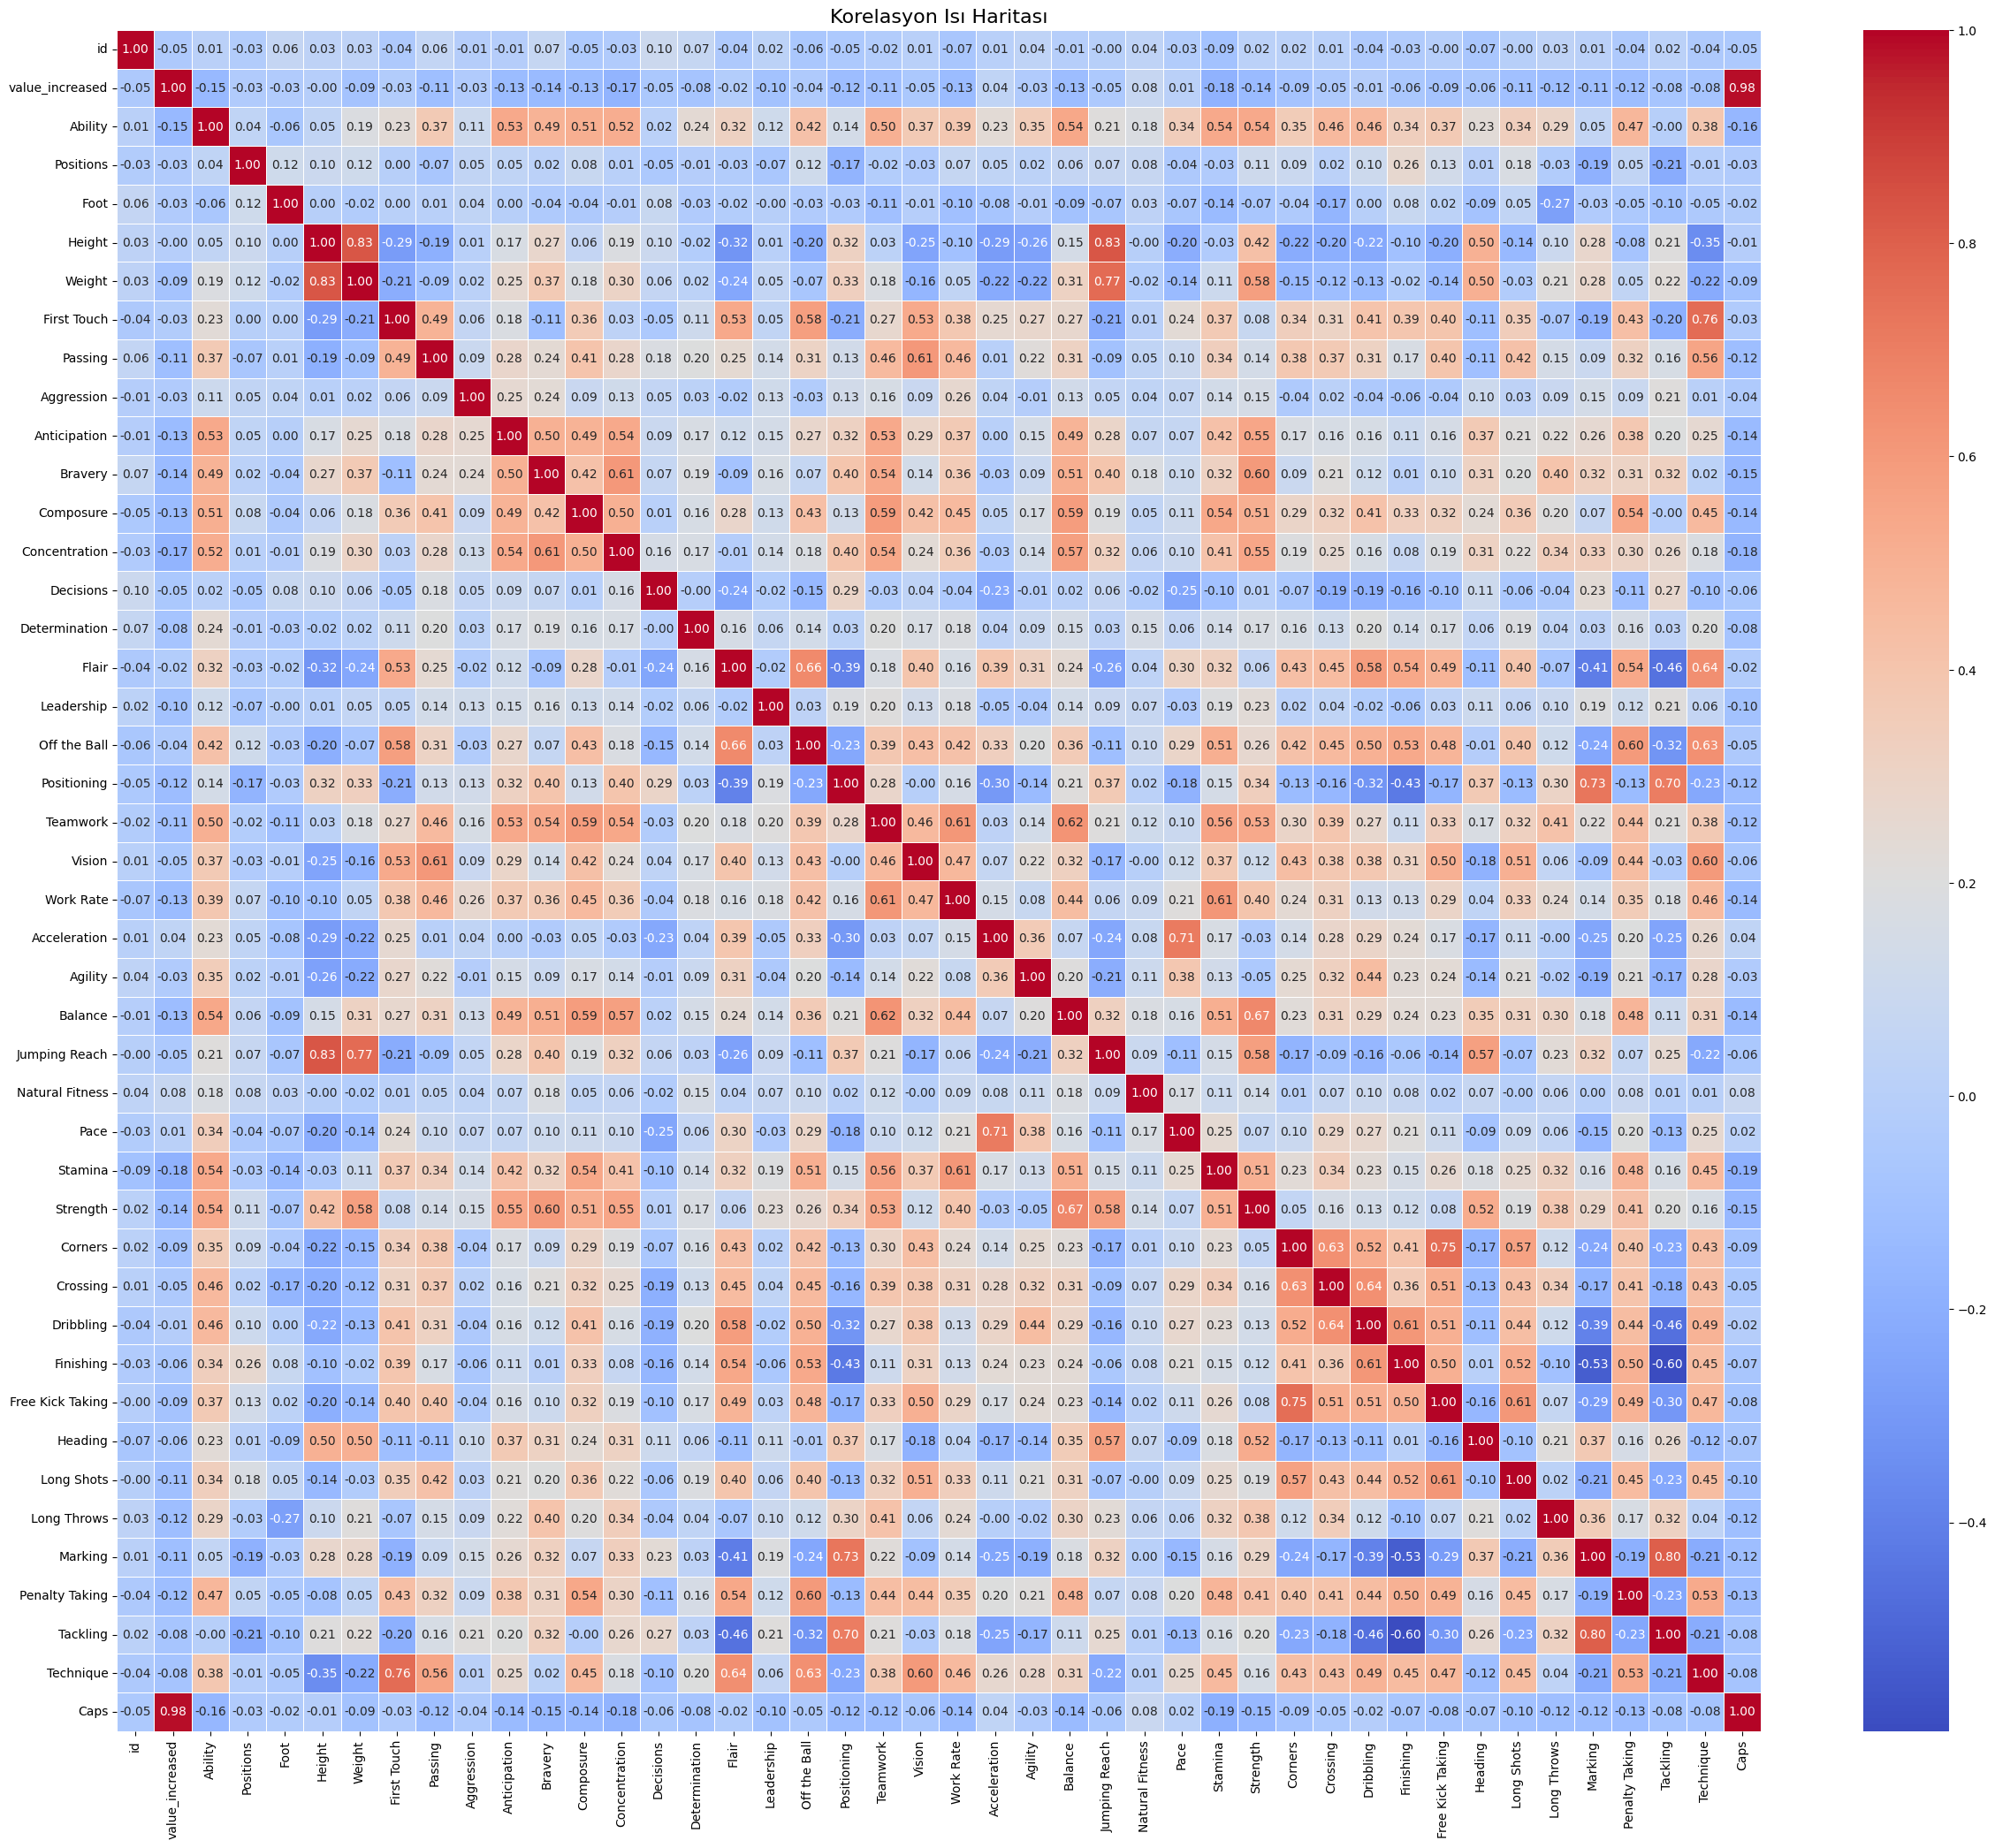

In [24]:
korelasyon_matrisi = train_df.corr()
plt.figure(figsize=(30, 25))
sns.heatmap(korelasyon_matrisi, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korelasyon Isı Haritası', fontsize=16)

##### Outlier Visualization

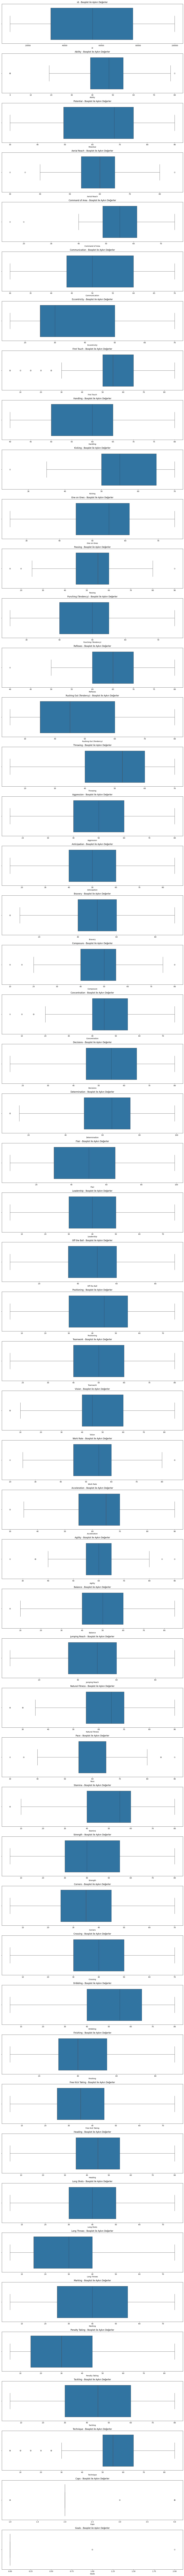

In [26]:
numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, len(numeric_columns) * 4))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(len(numeric_columns), 1, i)
    sns.boxplot(data=train[column], orient='h')
    plt.title(f'{column} - Boxplot ile Aykırı Değerler')

plt.tight_layout()
plt.show()

##### Value Increased Visualization

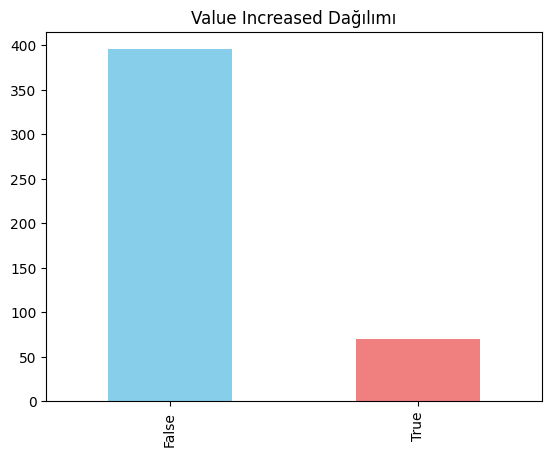

In [28]:
value_count = train_df['value_increased'].value_counts()
value_count.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Value Increased Dağılımı')
plt.show()

#### Modelling

In [30]:
X_train = train_df.drop('value_increased', axis=1)
y_train = train_df['value_increased']
X_test = test_df

##### Scaling Data and Balancing with SMOTE

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

##### Distribution Visualization

(465, 43)
(790, 43)


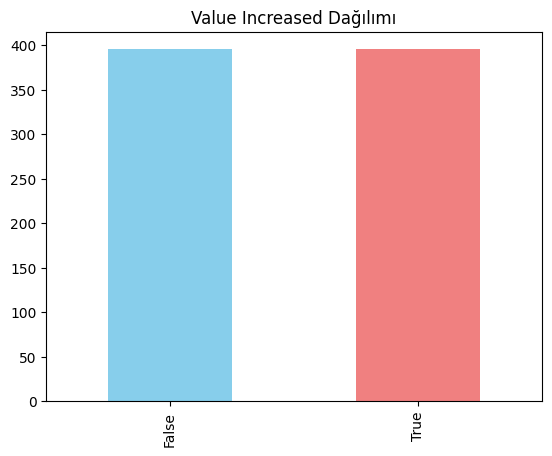

In [35]:
print(X_train_scaled.shape)
print(X_resampled.shape)
value_count = y_resampled.value_counts()
value_count.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Value Increased Dağılımı')
plt.show()

#### 4. Model Training and Evaluation

##### Model Definition and GridSearchCV Implementation

In [38]:
pd.set_option('display.max_colwidth', None)

models = {
    'Logistic Regression': (LogisticRegression(), {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['liblinear', 'saga']
    }),
    'Gradient Boosting Classifier': (GradientBoostingClassifier(), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7]
    }),
    'Random Forest Classifier': (RandomForestClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }),
    'Extra Trees Classifier': (ExtraTreesClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20]
    }),
    'AdaBoost Classifier': (AdaBoostClassifier(), {
        'n_estimators': [50, 100],
        'learning_rate': [1.0, 1.5]
    }),
    'Decision Tree Classifier': (DecisionTreeClassifier(), {
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5]
    }),
    'K Neighbors Classifier': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }),
    'Dummy Classifier': (DummyClassifier(strategy='most_frequent'), {}),
    'Extreme Gradient Boosting': (xgb.XGBClassifier(), {
        'n_estimators': [50, 100],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.1]
    }),
    'Light Gradient Boosting Machine': (lgb.LGBMClassifier(), {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1]
    }),
    'CatBoost Classifier': (CatBoostClassifier(learning_rate=0.1, depth=6, iterations=500, verbose=0), {}),
    'Hist Gradient Boosting Classifier': (HistGradientBoostingClassifier(), {
        'max_iter': [100, 200],
        'max_depth': [3, 5]
    }),
}

results = {}

# Her model için GridSearchCV uygulama
for name, (model, params) in models.items():
    if params:  # Eğer hiperparametreler varsa
        grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_resampled, y_resampled)
        
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy')
        
        results[name] = {
            'Best Params': best_params,
            'Best Score': best_score,
            'Mean Accuracy': scores.mean(),
            'Std Dev': scores.std()
        }
    else:
        # Hiperparametre ayarlaması gerektirmeyen modeller için basit bir değerlendirme
        scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy')
        results[name] = {
            'Mean Accuracy': scores.mean(),
            'Std Dev': scores.std()
        }

results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df.sort_values(by='Best Score', ascending=False))

[LightGBM] [Info] Number of positive: 395, number of negative: 395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8501
[LightGBM] [Info] Number of data points in the train set: 790, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

In [79]:
model = ExtraTreesClassifier(max_depth=10, n_estimators=50)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test_scaled)

In [81]:
submission = pd.read_csv("sample_submission.csv")
submission['value_increased'] = y_pred
submission.to_csv('submission.csv', index=False)

##### Learning Curve Drawing

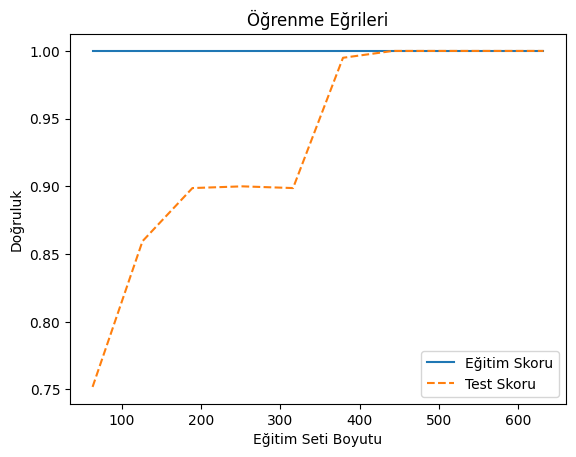

In [42]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_resampled, y_resampled, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, label='Eğitim Skoru', linestyle='-')
plt.plot(train_sizes, test_scores_mean, label='Test Skoru', linestyle='--')
plt.title('Öğrenme Eğrileri')
plt.xlabel('Eğitim Seti Boyutu')
plt.ylabel('Doğruluk')
plt.legend()
plt.show()